# Predicting Uber Rider Retention
### Chenxiang Li
---
## I. Definition
---
### Project Overview

Uber is interested in predicting rider retention. It would be very helpful for them to know what factors are most important for rider retention. To help explore this problem, they have provided a sample [dataset](https://www.dropbox.com/s/q5e3lqtma9dwmy6/uber_data_challenge.json?dl=0) of 50,000 users who signed up for an Uber account in January 2014. 

In this binary prediction project, I will apply classification algorithms in Python to predict Uber rider retention and explore feature importance. Eventually, I will provide data-driven suggestions to operationalize those insights to help Uber.


### Problem Statement
I would consider predicting rider retention as a supervised binary classification problem. The ultimate goal of this project is to find an machine learning algorithm to predict current rider retention and optimize retention rate by finding important features.

In this project, I will consider a rider retained if he/she was “active” (i.e. took a trip) in the preceding 30 days. Because the data was pulled several months later, I assumed the current date is `"2014-07-01"` and a user retained if the `last_trip_date` is after `"2014-06-01"`.

- I will complete data cleaning to fill missing values, remove outliers and also preprocess dataset for algorithm implementation.
- In exploratory phase, I will check basic statistics and rider segregation and train a Logistic Regression model as a benchmark.
- As for modeling, I will try Decision Tree, Random Forest and Support Vector Machine (SVM) classifiers to see which performs best on my training set. I will choose one algorithm for further reach to tune the respective parameters. 
- Finally, I will validate my model by cross-validation or on test set. Also, I will check the feature importance in the final model to provide suggestions for Uber.

### Dataset description

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYY­MM­DD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYY­MM­DD’ 
- avg_dist: the average distance *(in miles) per trip taken in the first 30 days after signup 
- avg_rating_by_driver: the rider’s average rating over all of their trips 
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips 
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips 
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- uber_black_user: TRUE if the user took an Uber Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

## II. Analysis
---
### Data Exploration

In [1]:
# Import modules
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
with open('train.json') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)
df.shape

(50000, 12)

In [3]:
# Explore data
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### Basic Statistics

In [4]:
df.describe()

/Users/chenxiangli/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,NaN,NaN,1.000000,0.000000,0.000000,33.300000
50%,3.880000,NaN,NaN,1.000000,0.000000,1.000000,66.700000
75%,6.940000,NaN,NaN,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


#### Missing values

In [28]:
# Count missing values by column
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
uber_black_user              0
weekday_pct                  0
dtype: int64

In [67]:
# Fill missing values with median
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median(), inplace = True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median(), inplace = True)

# Drop all rows with missing values in 'phone'
df = df.dropna().reset_index(drop = True)

# Doubel check missing values by column
df.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
uber_black_user           0
weekday_pct               0
dtype: int64

#### Outliers

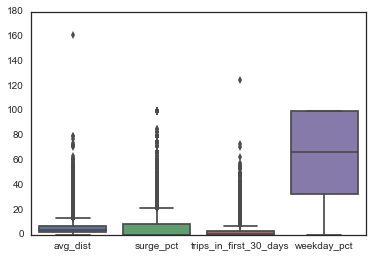

In [68]:
import seaborn as sns
%matplotlib inline

# Check outliers by boxplots
sns.boxplot(df[['avg_dist','surge_pct','trips_in_first_30_days','weekday_pct']])

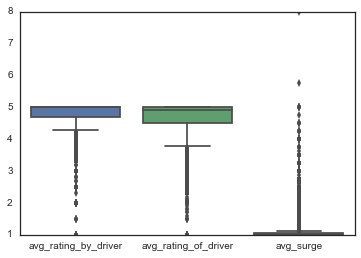

In [69]:
sns.boxplot(df[['avg_rating_by_driver','avg_rating_of_driver','avg_surge']])

#### Count outliers by columns

In [70]:
from collections import defaultdict
outliers = defaultdict(lambda: 0)

# For each feature find the data points with extreme high or low values
for feature in ('avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge', 'surge_pct','trips_in_first_30_days','weekday_pct'):
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = df[feature].quantile(0.25)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = df[feature].quantile(0.75) 
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    outliers_df = df[(df[feature] < (Q1 - step)) | (df[feature] > (Q3 + step))]

    for index in outliers_df.index.values:
        outliers[index] += 1
        
    print "Outliers for '{}':".format(feature), outliers_df.shape[0]

Outliers for 'avg_dist': 4477
Outliers for 'avg_rating_by_driver': 3922
Outliers for 'avg_rating_of_driver': 3106
Outliers for 'avg_surge': 8369
Outliers for 'surge_pct': 6768
Outliers for 'trips_in_first_30_days': 3153
Outliers for 'weekday_pct': 0


In [71]:
# Count outliers for more than one feature
outliers_list = [index for (index, count) in outliers.iteritems() if count > 1]
print "Number of outliers for more than one feature: {} ".format(len(outliers_list))

Number of outliers for more than one feature: 7805 


In [72]:
# Remove the outliers for more than one feature
df = df.drop(df.index[outliers_list]).reset_index(drop = True)
print df.shape

(41799, 12)


#### Non-numerical variables

In [73]:
# Check unique values for categorical variables
print "city:", (df.city.unique())
print "phone:", (df.phone.unique())

city: [u"King's Landing" u'Astapor' u'Winterfell']
phone: [u'iPhone' u'Android']


In [74]:
# Check range of date column
print "signup_date:", df['signup_date'].min(), df['signup_date'].max()
print "last_trip_date:", df['last_trip_date'].min(), df['last_trip_date'].max()

signup_date: 2014-01-01 2014-01-31
last_trip_date: 2014-01-01 2014-07-01


In [75]:
# Label predicted variable
# The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
# I would assume a user retained if the `last_trip_date` is after "2014-06-01" while assuming the current date is "2014-07-01".
df['active'] = df.last_trip_date >= '2014-06-01'

# Drop 'last_trip_date'
del df['last_trip_date']

# What's the null error rate? what percentage retented?
df["active"].mean()

0.37405201081365586

Only 37.6% riders retained, which means that I could obtain 62.4% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

In [76]:
df.dtypes # data types of columns

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
uber_black_user              bool
weekday_pct               float64
active                       bool
dtype: object

### Exploratory Visualization
---
#### Pair Scatter Plot

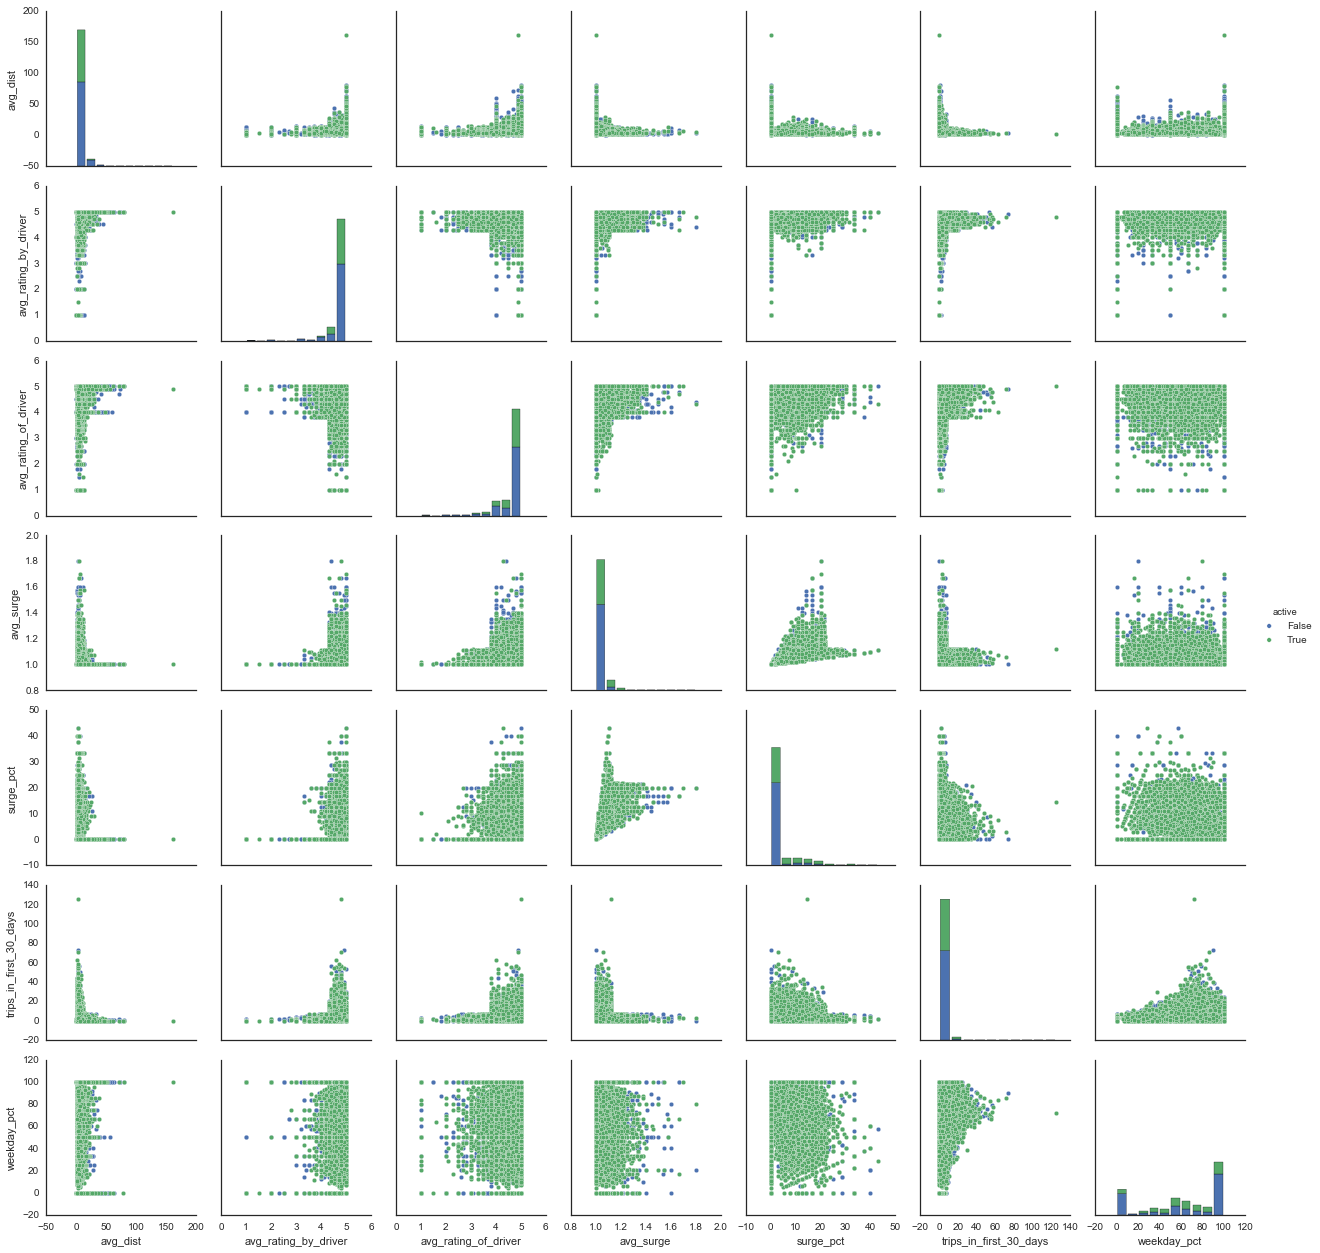

In [77]:
# Seperate quantitative features and categorical features
quant_features = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge', 'surge_pct','trips_in_first_30_days','weekday_pct', 'active']

# Visualize pairwise relationships between quantitative features 
sns.pairplot(df[quant_features], 
             hue = "active", 
             vars = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge', 'surge_pct','trips_in_first_30_days','weekday_pct']
            )

#### Correlation Matrix

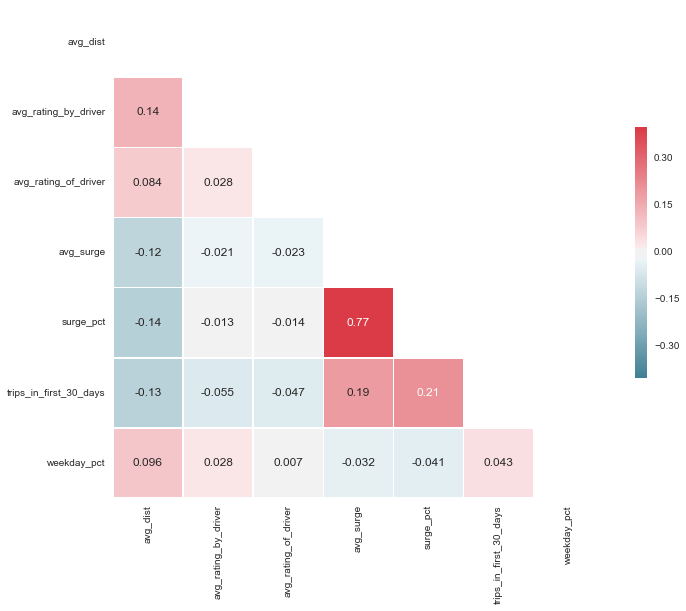

In [78]:
sns.set(style="white")

# Compute the correlation matrix
corr = df[['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge', 'surge_pct','trips_in_first_30_days','weekday_pct']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.4, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

#### Barplots for non-numerical features

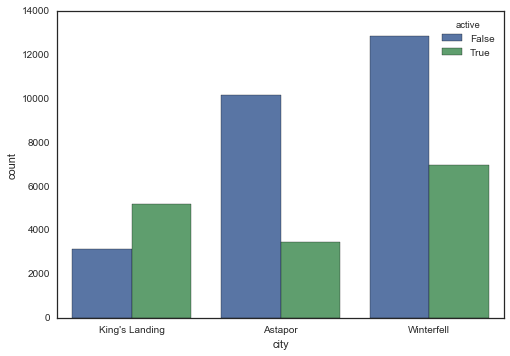

In [79]:
sns.countplot(x="city", hue="active", data=df)

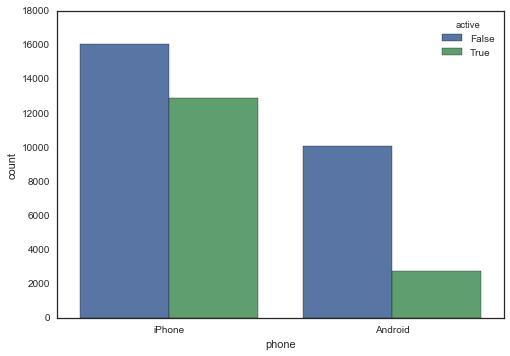

In [80]:
sns.countplot(x="phone", hue="active", data=df)

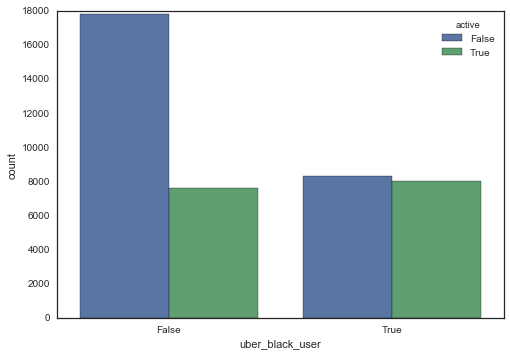

In [81]:
sns.countplot(x="uber_black_user", hue="active", data=df)

## III. Methodology
---
### Define Performance Metric

In [82]:
from sklearn.metrics import roc_auc_score

def performance_metric(y_true, y_predict):
    score = roc_auc_score(y_true, y_predict)  
    return score

### Data Preprocessing

In [83]:
from sklearn import preprocessing

# Encode all non-numerical variables
le = preprocessing.LabelEncoder()
df['city'] = le.fit_transform(df['city'])
df['phone'] = le.fit_transform(df["phone"])
df['signup_date'] = le.fit_transform(df["signup_date"])
# df['uber_black_user'] = le.fit_transform(df["uber_black_user"])
# train['phone'] = train['phone'].map({'iPhone': 1, 'Android': 0}).astype(float)
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                        int64
phone                       int64
signup_date                 int64
surge_pct                 float64
trips_in_first_30_days      int64
uber_black_user              bool
weekday_pct               float64
active                       bool
dtype: object

In [84]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,uber_black_user,weekday_pct,active
0,3.67,5.0,4.7,1.1,1,1,24,15.4,4,True,46.2,True
1,8.26,5.0,5.0,1.0,0,0,28,0.0,0,False,50.0,False
2,0.77,5.0,4.3,1.0,0,1,5,0.0,3,False,100.0,False
3,10.56,5.0,3.5,1.0,2,1,8,0.0,2,True,100.0,True
4,3.95,4.0,4.9,1.0,0,0,23,0.0,1,False,100.0,False


#### Shuffle and Split Data into training and testing sets 

In [85]:
from sklearn.cross_validation import train_test_split

y_all = df["active"]
X_all = df.drop('active', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=1)

### Benchmark

In [86]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model
lm = LogisticRegression()

# Train the model
lm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [87]:
# check the the accuracy by AUC score on the testing set
print performance_metric(y_train, lm.predict(X_train))
print performance_metric(y_test, lm.predict(X_test))

0.650485459542
0.654338556663


### Implementation

In [88]:
# Import the three supervised learning algorithms from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


# Initialize the three models
clf_A = KNeighborsClassifier()
clf_B = SVC(random_state=1)
clf_C = RandomForestClassifier(random_state=1)

# Loop through models, then return respective AUC scores
for clf in [clf_A, clf_B, clf_C]:
    print "\n{}: \n".format(clf.__class__.__name__)
    clf.fit(X_train, y_train)
    y_predict1 = clf.predict(X_train)
    y_predict = clf.predict(X_test)
    print performance_metric(y_train, y_predict1), performance_metric(y_test, y_predict)


KNeighborsClassifier: 

0.78022775816 0.697244988208

SVC: 

0.792745886852 0.712026938469

RandomForestClassifier: 

0.978383669576 0.721167695621


Base on my earlier experiments, `RandomForestClassifier` performs best on test data among all other algorithms. I would choose Random Forest for further optimization. 

### Refinement

In [89]:
# Import 'GridSearchCV' and 'make_scorer'
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        random forest classifier trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.30, random_state = 1)
    
    # Create a random forest classifier object
    clf = RandomForestClassifier(random_state=1)

    # Create a dictionary for the parameter 'max_features' and 'max_depth'
    parameters ={
                'max_features': [1,2,3,4,5,6,7,8,9,10,11],
                'max_depth': [1,2,3,4,5,6,7,8,9,10],
#                'n_estimators': [10,20,30,40,50,60,70,80,90,100], # Too slow to implement
                }

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    #grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scoring_fnc, cv=cv_sets)
    grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scoring_fnc, cv=cv_sets)
                                    

    # Fit the grid search object to the data to compute the optimal model
    grid_obj = grid_obj.fit(X, y)

    # Return the optimal model after fitting the data
    return grid_obj.best_estimator_

In [90]:
# Fit the training data to the model using grid search
clf = fit_model(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_predict = clf.predict(X_test)

print "Tuned model has a training AUROC score of {:.4f}.".format(performance_metric(y_train, y_train_predict))
print "Tuned model has a testing AUROC score of {:.4f}.".format(performance_metric(y_test, y_predict))
print "Parameter 'max_features' is {} for the optimal model.".format(clf.get_params()['max_features'])
print "Parameter 'max_depth' is {} for the optimal model.".format(clf.get_params()['max_depth'])
print "Parameter 'n_estimators' is {} for the optimal model.".format(clf.get_params()['n_estimators'])

Tuned model has a training AUROC score of 0.7693.
Tuned model has a testing AUROC score of 0.7564.
Parameter 'max_features' is 10 for the optimal model.
Parameter 'max_depth' is 8 for the optimal model.
Parameter 'n_estimators' is 10 for the optimal model.


In [91]:
# Change "n_estimators" to 100
clf = RandomForestClassifier(max_features=10, max_depth=8, n_estimators=100, random_state=1)
clf = clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_predict = clf.predict(X_test)

print "Tuned model has a training AUROC score of {:.4f}.".format(performance_metric(y_train, y_train_predict))
print "Tuned model has a testing AUROC score of {:.4f}.".format(performance_metric(y_test, y_predict))

Tuned model has a training AUROC score of 0.7713.
Tuned model has a testing AUROC score of 0.7571.


## IV. Results
---
### Model Evaluation and Validation

In [92]:
import sklearn.learning_curve as curves

def plt_max_features(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.3, random_state = 1)

    # Vary the max_depth parameter from 1 to 10
    features_range = np.arange(1,12)

    # Create a Random Forest classifier at optimal settings
    clf = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=1)
  
    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf, X, y, \
        param_name = "max_features", param_range = features_range, cv = cv, scoring = 'roc_auc')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Classifier Complexity Performance')
    plt.plot(features_range, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(features_range, test_mean, 'o-', color = 'g', label = 'Testing Score')
    plt.fill_between(features_range, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(features_range, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Features')
    plt.ylabel('AUROC Score')
    plt.ylim([0.83,0.88])
    plt.show()

def plt_max_depth(X, y):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    # Create 10 cross-validation sets for training and testing
    cv = ShuffleSplit(X.shape[0], n_iter = 10, test_size = 0.3, random_state = 1)

    # Vary the max_depth parameter from 1 to 10
    depth_range = np.arange(1,11)

    # Create a Random Forest classifier at optimal settings
    clf = RandomForestClassifier(max_features=10, n_estimators=100, random_state=1)
  
    # Calculate the training and testing scores
    train_scores, test_scores = curves.validation_curve(clf, X, y, \
        param_name = "max_depth", param_range = depth_range, cv = cv, scoring = 'roc_auc')

    # Find the mean and standard deviation for smoothing
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the validation curve
    plt.figure(figsize=(7, 5))
    plt.title('Random Forest Classifier Complexity Performance')
    plt.plot(depth_range, train_mean, 'o-', color = 'r', label = 'Training Score')
    plt.plot(depth_range, test_mean, 'o-', color = 'g', label = 'Testing Score')
    plt.fill_between(depth_range, train_mean - train_std, train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(depth_range, test_mean - test_std, test_mean + test_std, alpha = 0.15, color = 'g')
    
    # Visual aesthetics
    plt.legend(loc = 'lower right')
    plt.xlabel('Maximum Depth')
    plt.ylabel('AUROC Score')
    plt.ylim([0.60,0.95])
    plt.show()

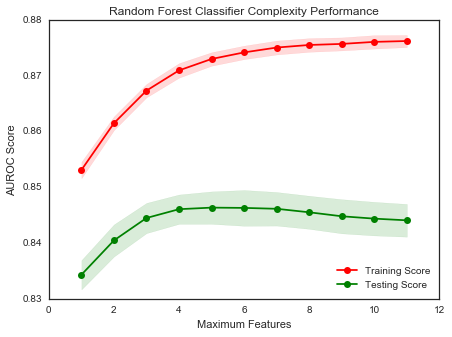

In [93]:
plt_max_features(X_train, y_train)

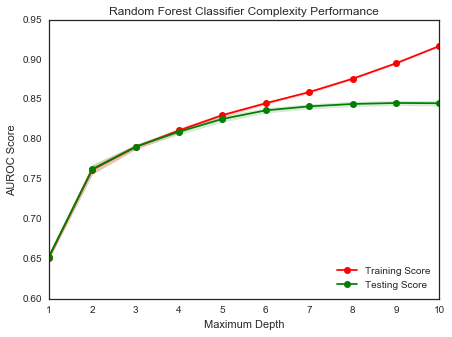

In [94]:
plt_max_depth(X_train, y_train)

In [95]:
clf = RandomForestClassifier(max_features=4, max_depth=9, n_estimators=100, random_state=1)
clf = clf.fit(X_train, y_train)
y_train_predict = clf.predict(X_train)
y_predict = clf.predict(X_test)

print "Tuned model has a training AUROC score of {:.4f}.".format(performance_metric(y_train, y_train_predict))
print "Tuned model has a testing AUROC score of {:.4f}.".format(performance_metric(y_test, y_predict))

Tuned model has a training AUROC score of 0.7734.
Tuned model has a testing AUROC score of 0.7512.


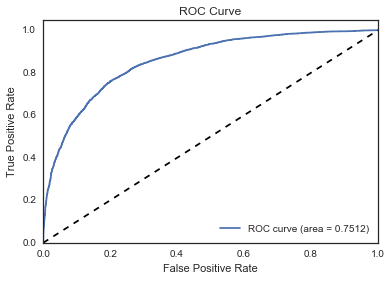

In [96]:
%matplotlib inline
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

roc_auc = roc_auc_score(y_test, y_predict)  

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

## V. Conclusion
---
### Feature Importance

Feature ranking:
                         0         1
7                surge_pct  0.193249
1     avg_rating_by_driver  0.164058
3                avg_surge  0.127574
4                     city  0.116354
10             weekday_pct  0.111231
5                    phone  0.073950
8   trips_in_first_30_days  0.061989
0                 avg_dist  0.050300
9          uber_black_user  0.048525
2     avg_rating_of_driver  0.026413
6              signup_date  0.026358


/Users/chenxiangli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


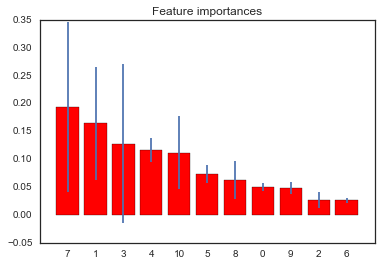

In [97]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Check feature importance
# for f in range(X_train.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
importances_df = pd.DataFrame(list(zip(X_train.columns, np.transpose(clf.feature_importances_)))).sort([1], ascending=False)
print importances_df

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [98]:
pd.DataFrame(list(zip(X_train.columns, np.transpose(clf.feature_importances_)))).sort([1], ascending=False)

/Users/chenxiangli/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,0,1
7,surge_pct,0.193249
1,avg_rating_by_driver,0.164058
3,avg_surge,0.127574
4,city,0.116354
10,weekday_pct,0.111231
5,phone,0.073950
8,trips_in_first_30_days,0.061989
0,avg_dist,0.050300
9,uber_black_user,0.048525
2,avg_rating_of_driver,0.026413
